# Churn Prediction Model

This notebook uses Python to predict which customers are likely to churn.  
It covers data cleaning, model training, and performance evaluation, with metrics and visual outputs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import shap


In [2]:
df = pd.read_csv("../data/customer_churn_clean_data.csv")
df.head()


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
df["Churn"].isna().sum()


np.int64(1)

In [4]:
df = df.dropna(subset=["Churn"])
df["Churn"] = df["Churn"].astype(int)


In [5]:
df = pd.get_dummies(df, drop_first=True)
df.head()



,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,2.0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,1,False,False,True,False,False
1,3.0,65.0,49.0,1.0,10.0,8.0,557.0,6.0,1,False,False,False,True,False
2,4.0,55.0,14.0,4.0,6.0,18.0,185.0,3.0,1,False,False,False,False,True
3,5.0,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1,True,False,True,True,False
4,6.0,23.0,32.0,20.0,5.0,8.0,617.0,20.0,1,True,False,False,True,False


In [6]:
df = df.drop(columns=["CustomerID"])


In [7]:
X = df.drop("Churn", axis=1)
y = df["Churn"]


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
scaled_df = pd.DataFrame(X_scaled, columns=X.columns) 
scaled_df.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,-1.145909,-0.713374,1.398594,-0.496232,-0.817258
1,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,-1.145909,-0.713374,-0.715004,2.015188,-0.817258
2,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,-1.145909,-0.713374,-0.715004,-0.496232,1.223604
3,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,0.872670,-0.713374,1.398594,2.015188,-0.817258
4,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,0.872670,-0.713374,-0.715004,2.015188,-0.817258


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[34558  3505]
 [ 5625 44479]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     38063
           1       0.93      0.89      0.91     50104

    accuracy                           0.90     88167
   macro avg       0.89      0.90      0.90     88167
weighted avg       0.90      0.90      0.90     88167



In [12]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
y_rf_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))


[[38061     2]
 [   32 50072]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38063
           1       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



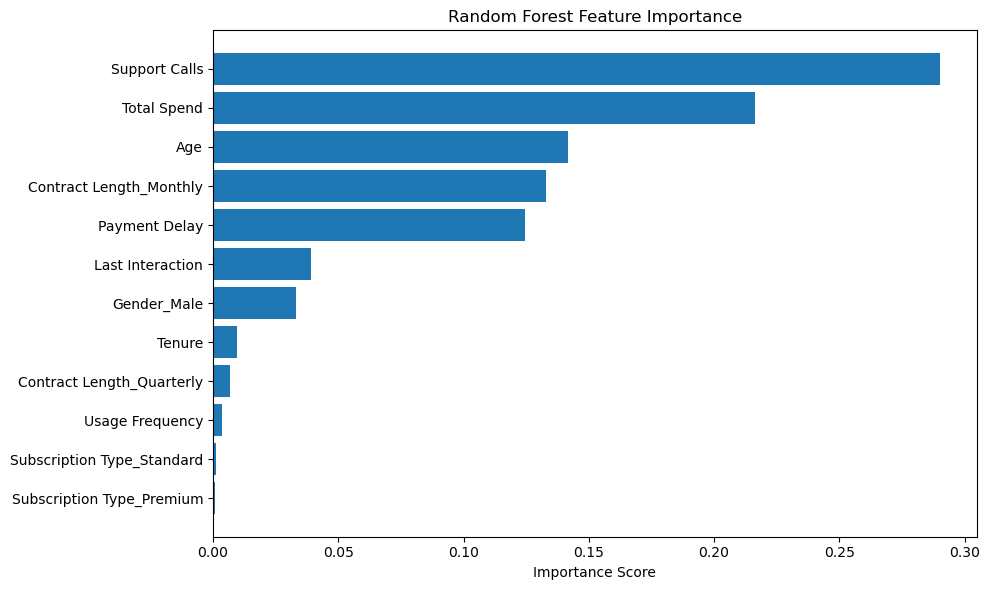

In [14]:
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [15]:
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(12)


Support Calls                 0.290269
Total Spend                   0.216394
Age                           0.141831
Contract Length_Monthly       0.132840
Payment Delay                 0.124357
Last Interaction              0.039243
Gender_Male                   0.033067
Tenure                        0.009614
Contract Length_Quarterly     0.006674
Usage Frequency               0.003707
Subscription Type_Standard    0.001068
Subscription Type_Premium     0.000936
dtype: float64

In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_scaled, y, cv=5)
print(scores, scores.mean())



[0.99964839 0.99961437 0.9997051  0.99960302 0.99951228] 0.9996166339342543


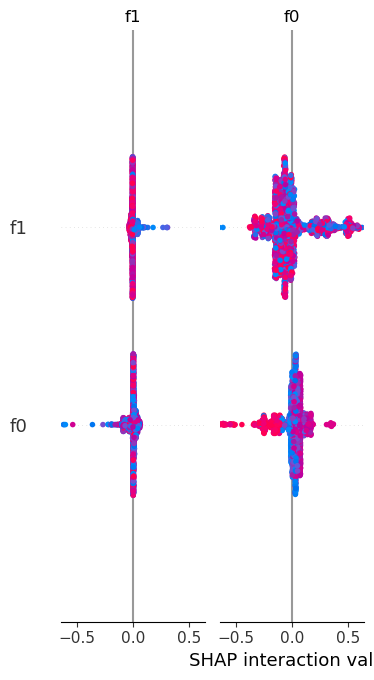

In [17]:
n = 2000
sample = pd.DataFrame(X_test[:min(n, X_test.shape[0])], columns=[f"f{i}" for i in range(X_test.shape[1])])
explainer = shap.TreeExplainer(rf_model)
sv = explainer.shap_values(sample, check_additivity=False)
vals = sv[1] if isinstance(sv, list) and len(sv) > 1 else (sv if not isinstance(sv, list) else sv[0])
shap.summary_plot(vals, sample)


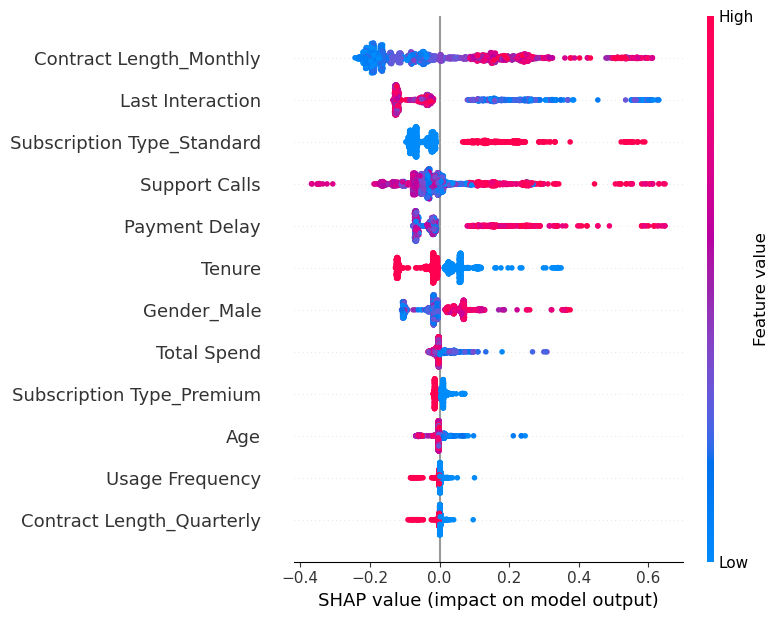

<Figure size 640x480 with 0 Axes>

In [18]:
n = 2000
feature_names = [
    "Support Calls","Total Spend","Age","Contract Length_Monthly",
    "Payment Delay","Last Interaction","Gender_Male","Tenure",
    "Contract Length_Quarterly","Usage Frequency",
    "Subscription Type_Standard","Subscription Type_Premium"
]
sample = pd.DataFrame(X_test[:min(n, X_test.shape[0])], columns=feature_names)
explainer = shap.TreeExplainer(rf_model)
sv = explainer.shap_values(sample, check_additivity=False)

if isinstance(sv, list):
    vals = sv[1] if len(sv) > 1 else sv[0]
else:
    arr = np.array(sv)
    if arr.ndim == 3:
        vals = arr[:, :, 1] if arr.shape[2] > 1 else arr[:, :, 0]
    elif arr.ndim == 2:
        vals = arr
    else:
        vals = np.mean(arr, axis=0)

shap.summary_plot(vals, sample, plot_type="dot")
plt.tight_layout()


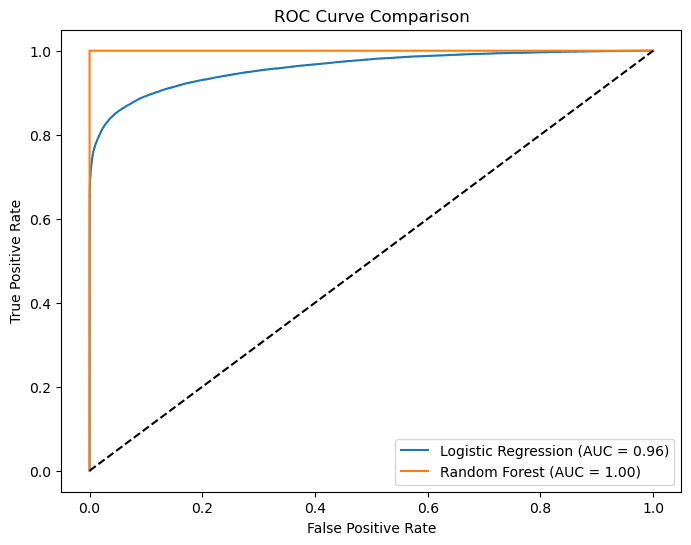

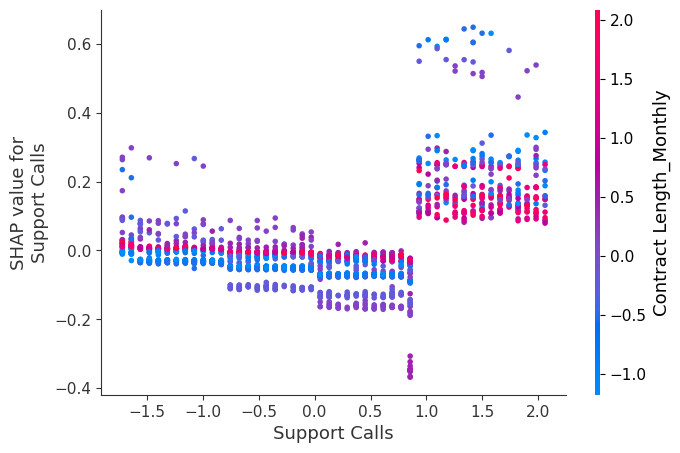

In [19]:
from sklearn.metrics import roc_curve, auc

y_lr_prob = model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

y_rf_prob = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

shap.dependence_plot("Support Calls", vals, sample)


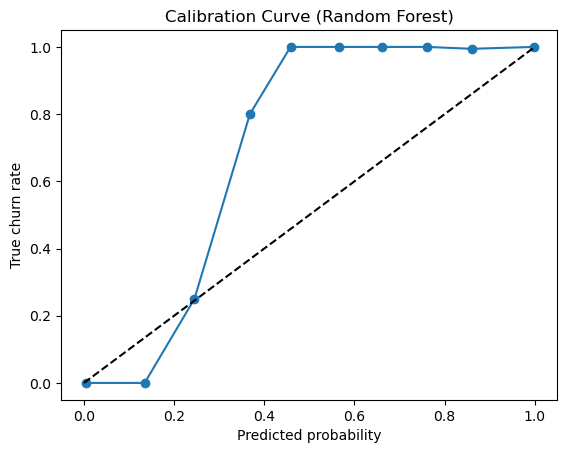

In [20]:
from sklearn.calibration import calibration_curve

y_rf_prob = rf_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_rf_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted probability")
plt.ylabel("True churn rate")
plt.title("Calibration Curve (Random Forest)")
plt.show()
